In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/My Drive/ML_289_Final_Project/ML_Fake_News_Detector-master/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1GN8bHASZPbpskLCKQbbuNezj76m4AVxc/ML_289_Final_Project/ML_Fake_News_Detector-master


In [0]:
%load_ext autoreload
%autoreload 2

#import classifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from src.data_util import Data 
DATA_DIR = './News-Media-Reliability/data/'
corpus_filename = DATA_DIR + 'corpus.csv'

In [0]:
data_obj = Data(corpus_filename,DATA_DIR)

tensor_x = torch.Tensor(data_obj.X)
tensor_y_fact = torch.Tensor(data_obj.y['fact']).type(torch.LongTensor)
tensor_y_bias = torch.Tensor(data_obj.y['bias']).type(torch.LongTensor)

fact_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y_fact)
bias_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y_bias)

train_size = int(0.8 * len(fact_dataset))
test_size = len(fact_dataset) - train_size
fact_train_dataset, fact_test_dataset = torch.utils.data.random_split(fact_dataset, [train_size, test_size])
bias_train_dataset, bias_test_dataset = torch.utils.data.random_split(bias_dataset, [train_size, test_size])

fact_trainloader = torch.utils.data.DataLoader(fact_train_dataset, batch_size=4, shuffle=True, num_workers=2)
fact_testloader = torch.utils.data.DataLoader(fact_test_dataset, batch_size=4, shuffle=False, num_workers=2)

bias_trainloader = torch.utils.data.DataLoader(bias_train_dataset, batch_size=4, shuffle=True, num_workers=2)
bias_testloader = torch.utils.data.DataLoader(bias_test_dataset, batch_size=4, shuffle=False, num_workers=2)

fact_classes = ('low', 'mixed', 'high')
bias_classes = ('extreme-right', 'right', 'center-right', 'center', 'center-left', 'left', 'extreme-left')

                                 source_url  ...           bias
0              http://www.villagevoice.com/  ...           left
1            https://insideclimatenews.org/  ...    left-center
2                     http://www.fury.news/  ...  extreme-right
3                      http://now8news.com/  ...         center
4                  http://constitution.com/  ...  extreme-right
...                                     ...  ...            ...
1061               http://fusion.kinja.com/  ...    left-center
1062                     http://aptnnews.ca  ...         center
1063                    http://www.wsws.org  ...           left
1064  https://www.spin.com/death-and-taxes/  ...           left
1065                    http://www.aina.org  ...          right

[1066 rows x 5 columns]
Before 6.94930531520835e-310
handcrafted_url.npy 44.0
44.0 

wikitoc.npy 6.0
44.0 

title.npy 47.5966625966626
47.5966625966626 

body.npy 2653.733333333333
2653.733333333333 

url_match.npy 6.0
2653.7333333

In [0]:
class FactNet(nn.Module):

    def __init__(self):
        super(FactNet, self).__init__()
        self.fc1 = nn.Linear(1808, 900) 
        self.fc2 = nn.Linear(900, 3)
        #self.fc3 = nn.Linear(600, 3)
        #self.fc4 = nn.Linear(400, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = F.softmax(self.fc2(x), dim = 1)
        return x

In [0]:
class BiasNet(nn.Module):

    def __init__(self):
        super(BiasNet, self).__init__()
        self.fc1 = nn.Linear(1808, 900) 
        self.fc2 = nn.Linear(900, 7)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = 1)
        return x

In [0]:
def calc_accuracy(net, data_loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in data_loader:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the %d test images: %.3f %%' % (total,
      100 * correct / total))
  return correct / total

In [0]:
fact_net = FactNet()
bias_net = BiasNet()
criterion = nn.CrossEntropyLoss()
fact_optimizer = optim.Adam(fact_net.parameters(), lr=0.00001)
bias_optimizer = optim.Adam(bias_net.parameters(), lr=0.00001)

Loss at epoch 0 : 0.260
Accuracy of the network on the 852 test images: 49.765 %
Accuracy of the network on the 214 test images: 52.804 %
Loss at epoch 1 : 0.249
Accuracy of the network on the 852 test images: 60.563 %
Accuracy of the network on the 214 test images: 59.346 %
Loss at epoch 2 : 0.241
Accuracy of the network on the 852 test images: 61.385 %
Accuracy of the network on the 214 test images: 57.477 %
Loss at epoch 3 : 0.239
Accuracy of the network on the 852 test images: 61.620 %
Accuracy of the network on the 214 test images: 58.879 %
Loss at epoch 4 : 0.238
Accuracy of the network on the 852 test images: 60.798 %
Accuracy of the network on the 214 test images: 60.280 %
Loss at epoch 5 : 0.235
Accuracy of the network on the 852 test images: 62.089 %
Accuracy of the network on the 214 test images: 61.215 %
Loss at epoch 6 : 0.234
Accuracy of the network on the 852 test images: 61.502 %
Accuracy of the network on the 214 test images: 62.617 %
Loss at epoch 7 : 0.235
Accuracy o

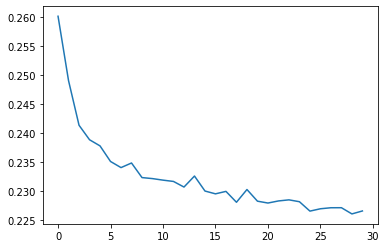

In [0]:
loss_values = []
train_acc_f = []
val_acc_f = []
for epoch in range(30): 

    running_loss = 0.0
    total = 0
    for i, data in enumerate(fact_trainloader, 0):
        inputs, labels = data
        fact_optimizer.zero_grad()

        outputs = fact_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        fact_optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)

    print('Loss at epoch %d : %.3f' % (epoch, running_loss/total))
    loss_values.append(running_loss/total)
    train_acc_f.append(calc_accuracy(fact_net, fact_trainloader))
    val_acc_f.append(calc_accuracy(fact_net, fact_testloader))

print('Finished Fact Training')
plt.plot(loss_values)

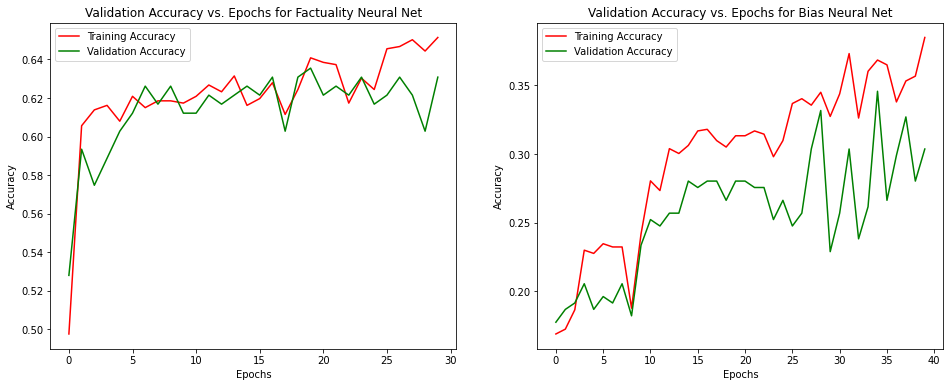

In [0]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(16)
ax1.set_title("Validation Accuracy vs. Epochs for Factuality Neural Net")
ax2.set_title("Validation Accuracy vs. Epochs for Bias Neural Net")
ax1.plot(train_acc_f, 'r', label = "Training Accuracy")
ax1.plot(val_acc_f, 'g', label = "Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax2.plot(train_acc_b, 'r', label = "Training Accuracy")
ax2.plot(val_acc_b, 'g', label = "Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend();


Loss at epoch 0 : 0.507
Accuracy of the network on the 852 test images: 16.901 %
Accuracy of the network on the 214 test images: 17.757 %
Loss at epoch 1 : 0.494
Accuracy of the network on the 852 test images: 17.254 %
Accuracy of the network on the 214 test images: 18.692 %
Loss at epoch 2 : 0.493
Accuracy of the network on the 852 test images: 18.662 %
Accuracy of the network on the 214 test images: 19.159 %
Loss at epoch 3 : 0.486
Accuracy of the network on the 852 test images: 23.005 %
Accuracy of the network on the 214 test images: 20.561 %
Loss at epoch 4 : 0.483
Accuracy of the network on the 852 test images: 22.770 %
Accuracy of the network on the 214 test images: 18.692 %
Loss at epoch 5 : 0.485
Accuracy of the network on the 852 test images: 23.474 %
Accuracy of the network on the 214 test images: 19.626 %
Loss at epoch 6 : 0.483
Accuracy of the network on the 852 test images: 23.239 %
Accuracy of the network on the 214 test images: 19.159 %
Loss at epoch 7 : 0.482
Accuracy o

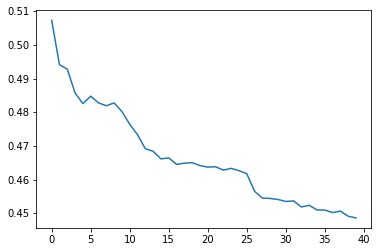

In [0]:
loss_values = []
train_acc_b = []
val_acc_b = []
for epoch in range(40): 

    running_loss = 0.0
    total = 0
    for i, data in enumerate(bias_trainloader, 0):
        inputs, labels = data
        bias_optimizer.zero_grad()

        outputs = bias_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        bias_optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)

    print('Loss at epoch %d : %.3f' % (epoch, running_loss/total))
    loss_values.append(running_loss/total)
    train_acc_b.append(calc_accuracy(bias_net, bias_trainloader))
    val_acc_b.append(calc_accuracy(bias_net, bias_testloader))

print('Finished Bias Training')
plt.plot(loss_values);

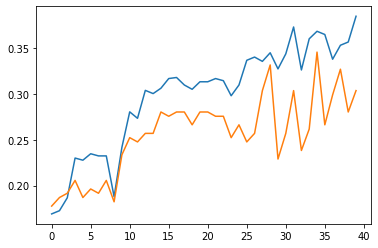

In [0]:
plt.plot(train_acc_b)
plt.plot(val_acc_b)

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in fact_testloader:
        images, labels = data
        outputs = fact_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %.3f %%' % (total,
    100 * correct / total))

Accuracy of the network on the 214 test images: 63.084 %


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in bias_testloader:
        images, labels = data
        outputs = bias_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %.3f %%' % (total,
    100 * correct / total))

Accuracy of the network on the 214 test images: 30.374 %


In [0]:
class_correct = list(0. for i in range(len(fact_classes)))
class_total = list(0. for i in range(len(fact_classes)))
with torch.no_grad():
    for data in fact_testloader:
        images, labels = data
        outputs = fact_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(fact_classes)):
    print('Accuracy of %5s : %2d %%' % (
        fact_classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   low : 66 %
Accuracy of mixed :  0 %
Accuracy of  high : 92 %


In [0]:
class_correct = list(0. for i in range(len(bias_classes)))
class_total = list(0. for i in range(len(bias_classes)))
with torch.no_grad():
    for data in bias_testloader:
        images, labels = data
        outputs = bias_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(bias_classes)):
    print('Accuracy of %5s : %2d %%' % (
        bias_classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of extreme-right : 50 %
Accuracy of right :  0 %
Accuracy of center-right :  0 %
Accuracy of center : 62 %
Accuracy of center-left : 37 %
Accuracy of  left : 17 %
Accuracy of extreme-left :  0 %


In [0]:
# x = torch.randn(1)
# print(x)
# print(x.item())

# if torch.cuda.is_available():
#     device = torch.device("cuda")        
#     y = torch.ones_like(x, device=device)  
#     x = x.to(device)                       
#     z = x + y
#     print(z)
#     print(z.to("cpu", torch.double)) 